# Importing the Libraries

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
from csv import writer
import requests
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Web Scraping

### Scraping Hürriyet Emlak website to get area, building ages and price of for sale houses

In [10]:
def web_scraping():    
    url = "https://www.hepsiemlak.com/istanbul-satilik?page="

    with open('housing.csv','w', encoding='utf8',newline='') as f:

        csv_writer = writer(f)
        header = ['Area', 'Building Age', 'Price']
        csv_writer.writerow(header)

        for page in range(1,30):
            page = requests.get(url + str(page))
            soup = BeautifulSoup(page.content, 'html.parser')
            lists = soup.find_all('div', class_ = "list-view-line")

            for line in lists:
                price = line.find('div', class_='list-view-price').text.replace('\n','').replace('.', '')[:-2]
                building_age = line.find('span', class_='celly buildingAge').text.replace('\n','').replace('.', '')[:2]
                area = line.find('span', class_= 'celly squareMeter list-view-size').text.replace('\n','').replace('.', '')[:-2]
                csv_writer.writerow([area, building_age, price])
                
    return "Scraping successful"

In [11]:
web_scraping()

'Scraping successful'

# Linear Regression Function

In [62]:
def LinearRegression(covariates,targets):
    #Creating arrays
    covariates = covariates.dropna().to_numpy()
    targets = targets.dropna().to_numpy()
    targets = targets.reshape(-1,1)


    #Dimensions
    n = covariates.shape[0]
    k = covariates.shape[1]

    #Vector of ones should be created for intercept values
    ones = np.ones((n,1))

    #Appending vector of ones to X
    covariates = np.concatenate((ones, covariates), axis=1)

    #Calculating beta
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(covariates),covariates)),np.transpose(covariates)),targets)
    beta = beta.reshape(-1,1)

    #Calculating predictions
    y_hat = np.matmul(covariates,beta)
    y_hat = y_hat.reshape(-1,1)

    #Calculating errors
    e = np.subtract(targets, y_hat)

    #Calculating variance
    variance = float(np.matmul(np.transpose(e),e) / (n - k - 1)) #Since the intercept terms not included in degrees of freedom, k* = k+1

    #Calculating variance of beta
    var_beta = np.diag(np.multiply(variance, np.linalg.inv(np.matmul(np.transpose(covariates),covariates))))
    var_beta = var_beta.reshape(-1,1)

    #Calculating errors of beta
    standard_error = np.sqrt(var_beta)
    standard_error = standard_error.reshape(-1,1)

    #Calculating lower and upper bound for credible interval of 95%
    t = stats.t.ppf((1+0.95)/2., (covariates.shape[0] - covariates.shape[1]-1))

    lower_bound = np.subtract(beta, t*standard_error)
    upper_bound = np.add(beta, t*standard_error)

    return beta, standard_error, lower_bound, upper_bound, covariates, targets

# Scatter Plot of Data Points

In [35]:
data = pd.read_csv('housing.csv')
data = data[data['Building Age'].apply(lambda x: x.isnumeric())]
data['Price'] = data['Price'].astype(int)
data['Building Age'] = data['Building Age'].astype(int)

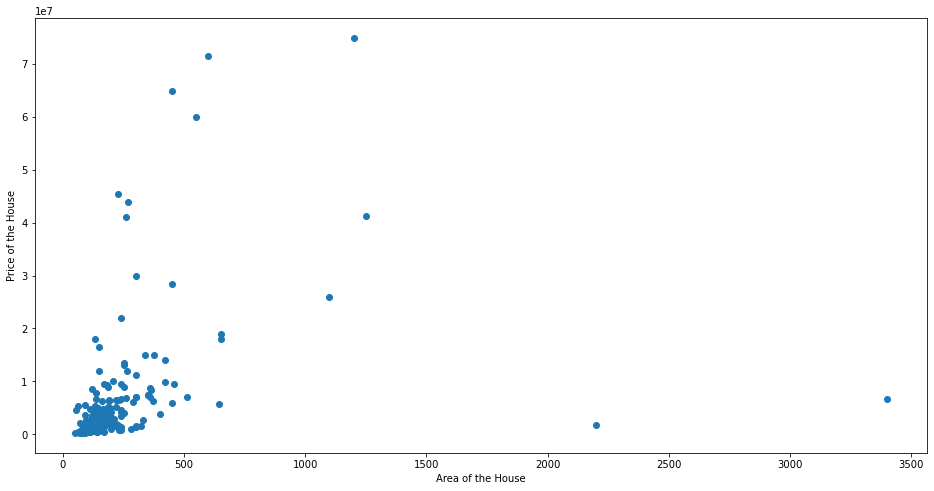

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Area'], data['Price'])
ax.set_xlabel('Area of the House')
ax.set_ylabel('Price of the House')
plt.show()

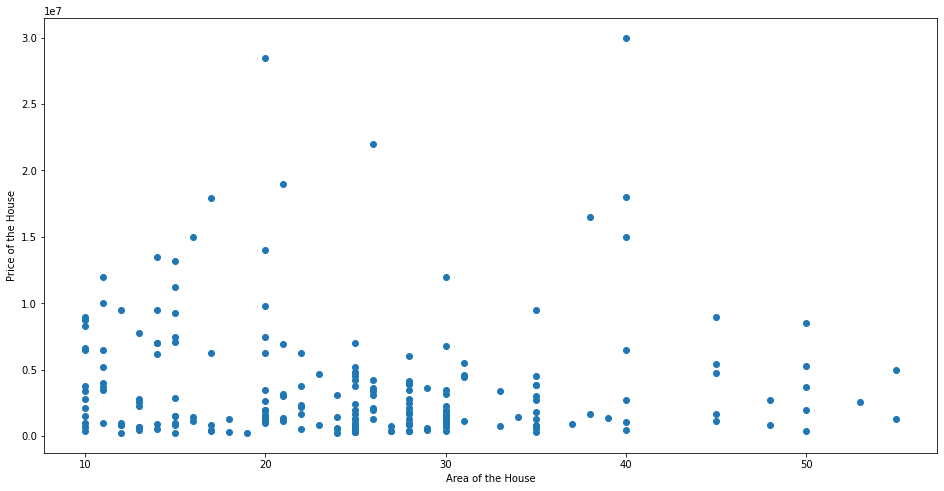

In [44]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Building Age'], data['Price'])
ax.set_xlabel('Area of the House')
ax.set_ylabel('Price of the House')
plt.show()

As it can be seen, we have some outliers which may disturb the linear regression model. Thus, those points need to be removed from the data set.

# Dealing with Outliers

In [39]:
z = np.abs(stats.zscore(data))
print(z)

         Area  Building Age     Price
0    0.118588      0.312296  0.168739
3    0.272942      0.829536  0.159541
13   0.272942      1.102795  0.207551
15   0.550282      0.839296  0.876511
21   0.032835      1.278462  0.411955
..        ...           ...       ...
534  0.187190      0.751462  0.063539
541  0.221491      0.048796  0.453976
543  0.238641      0.829536  0.099056
545  0.018616      0.927129  0.377789
548  0.087218      0.400129  0.401017

[234 rows x 3 columns]


In [42]:
#We give threshold of 3 for the z scores in order to remove the outliers
data = data[(z < 3).all(axis=1)]

# Scaling data in order to fit Linear Regression

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler()

In [47]:
data_scaled = data.copy()

In [48]:
data_scaled[['Area','Building Age','Price']] = scaler.fit_transform(data_scaled[["Area",'Building Age', "Price"]])

# Determining covariate and target values and performing Linear Regression

In [64]:
covariates = data_scaled[['Area', 'Building Age']]
targets = data_scaled['Price']

In [65]:
beta, standard_error, lower_bound, upper_bound, covariates, targets = LinearRegression(covariates,targets)

In [66]:
df = pd.DataFrame(list(zip(beta, standard_error, lower_bound, upper_bound)), 
               columns =['beta', 'Standard Error', 'Lower 95%', 'Upper 95%']) 
print(df)

                    beta          Standard Error               Lower 95%  \
0  [-0.0448451874217035]  [0.019884093686643334]  [-0.08403586715363964]   
1   [0.6323724599294093]  [0.051796719448689986]    [0.5302833893854434]   
2    [0.098805678165897]   [0.03684687515292847]  [0.026182097428542883]   

                 Upper 95%  
0  [-0.005654507689767357]  
1     [0.7344615304733751]  
2     [0.1714292589032511]  


# Plotting the Models

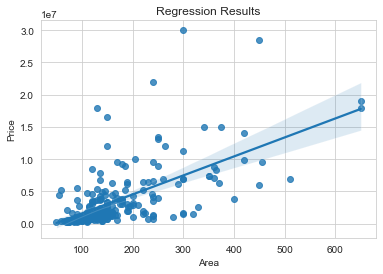

In [98]:
fig = sns.regplot(x="Area", y="Price", data=data)
sns.set_style("whitegrid")
plt.title("Regression Results")
plt.show()


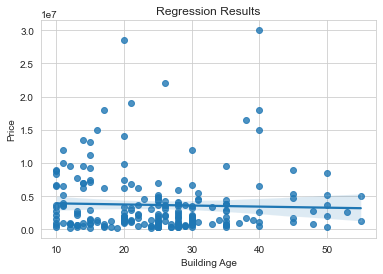

In [99]:
fig = sns.regplot(x="Building Age", y="Price", data=data)
sns.set_style("whitegrid")
plt.title("Regression Results")
plt.show()

# Summary table from OLS Statsmodels

In [77]:
X = data_scaled[['Area', 'Building Age']]
y = data_scaled['Price']

In [79]:
#Adding constant to X
X = sm.add_constant(X)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
SM_model = sm.OLS(y,X).fit()
print(SM_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     74.76
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.89e-25
Time:                        14:13:24   Log-Likelihood:                 158.13
No. Observations:                 221   AIC:                            -310.3
Df Residuals:                     218   BIC:                            -300.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0448      0.020     -2.255   